---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : "Ehab Kamal Soliman"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

c:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [2]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [3]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


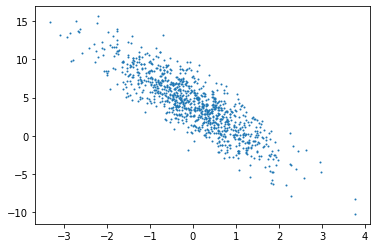

In [5]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    
    if is_train:
        dataset = dataset.shuffle(buffer_size=len(dataset))
        
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [8]:
### YOUR CODE HERE ###
iterator = iter(data_iter)

print(iterator.next())

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.44109643,  0.29733023],
       [-0.3781467 , -0.6147702 ],
       [-0.06459253,  0.17957735],
       [-1.2765387 , -0.67146075],
       [ 0.7718837 ,  1.4932712 ],
       [ 0.19340073, -0.240537  ],
       [ 1.6647202 , -1.199883  ],
       [ 1.0729338 , -0.04161261],
       [-0.05411331,  0.14211723],
       [-0.34596956, -0.5312256 ]], dtype=float32)>, <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 2.2935514],
       [ 5.5324187],
       [ 3.4383585],
       [ 3.9346645],
       [ 0.6701123],
       [ 5.3922973],
       [11.598939 ],
       [ 6.4856396],
       [ 3.6075172],
       [ 5.282805 ]], dtype=float32)>)


4. **Explain what the output shape in the prvious tensors means:**


**Answer:** 
- the output shape in the first tensor means that it consists of 10 examples with 2 features each 
- the output shape in the second tensor means that it has 10 labels corresponding to the 10 examples of the first tensor

5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:**
- the dataset has 1000 examples divided into 10 examples each batch. So, data_iter has 100 batches

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [9]:
## YOUR CODE HERE ##
w = tf.Variable(tf.random.normal(shape=(2,1), mean=0, stddev=0.02))
b = tf.Variable(0.0)

print(w)
print(b)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.00074006],
       [0.00691857]], dtype=float32)>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>


### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [10]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """
    ## YOUR CODE HERE ##
    y_hat = tf.matmul(X, w) + b

    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [11]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    loss = tf.reduce_mean(tf.square(y_hat - y))
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [12]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    ## YOUR CODE HERE ##
    
    params["w"].assign_sub(grads[0] * lr)
    params["b"].assign_sub(grads[1] *lr)

### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [13]:
lr = 0.02
num_epochs = 5
net = linreg
loss = squared_loss

In [14]:
## YOUR CODE HERE ## The loop code
for epoch in range(num_epochs):
    for batch in data_iter:
        params = {"w":w, "b":b}
        with tf.GradientTape() as tape:
            preds = net(batch[0],params["w"],params["b"])
            l = loss(preds, batch[1])
        
        grads = tape.gradient(l, [w,b])
        
        sgd(params,grads,lr,batch_size)
        
    print(f"Loss: {loss(net(features,w,b), labels)}")

Loss: 0.014729084447026253
Loss: 0.00011181980516994372
Loss: 0.00010706821194617078


Loss: 0.00010730414214776829
Loss: 0.00010692484647734091


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!


In [15]:
## YOUR CODE HERE ##
print(f'error in estimating w: {tf.reshape(true_w,(2,1)) - w}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [[-0.00084329]
 [-0.00083923]]
error in estimating b: 0.0002465248107910156


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [16]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
d_data = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [17]:
## YOUR CODE HERE ##

### Look at keys to determine the data

d_data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

3. **Use the key DESCR to understand the dataset**

In [18]:
## YOUR CODE HERE ##
print(d_data["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [19]:
### START CODE HERE ### (≈ 2 lines of code)
data = d_data["data"]
targets = d_data["target"]
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [20]:
### START CODE HERE ###
df = pd.DataFrame(data)
df["target"] = targets 
df.describe()
### END CODE HERE ###

,0,1,2,3,4,5,6,7,8,9,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [21]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.1)

### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER: Yes, because normalizing features helps optimizer function converge faster 

7. **normalize the targets**

In [22]:
### START CODE HERE ### (≈ 6 lines of code)
for col in train_data.columns:
    train_data[col] = (train_data[col] - train_data[col].mean()) / train_data[col].std()
    test_data[col] = (test_data[col] - train_data[col].mean()) / train_data[col].std()
### END CODE HERE ###


In [23]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9
count,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02
mean,2.460948e-17,4.474450e-17,-1.789780e-17,-2.684670e-17,-4.027005e-17,9.508207e-18,1.342335e-17,1.789780e-17,2.237225e-17,-2.237225e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.233723e+00,-9.665538e-01,-1.872105e+00,-2.356188e+00,-2.326391e+00,-2.455404e+00,-2.144392e+00,-1.602556e+00,-2.612001e+00,-2.848191e+00
25%,-8.000119e-01,-9.665538e-01,-7.262614e-01,-7.575315e-01,-7.267454e-01,-6.345465e-01,-7.585612e-01,-8.366968e-01,-6.922916e-01,-7.077885e-01
50%,1.054898e-01,-9.665538e-01,-1.645732e-01,-1.035356e-01,-8.688710e-02,-8.037251e-02,-1.426363e-01,-7.083719e-02,-9.221753e-02,-2.285971e-02
75%,7.846161e-01,1.031998e+00,6.442577e-01,6.957927e-01,6.111402e-01,5.793585e-01,6.272699e-01,6.950224e-01,6.782293e-01,5.764530e-01
max,2.293786e+00,1.031998e+00,3.565036e+00,2.803113e+00,3.228742e+00,4.168295e+00,3.783885e+00,3.827388e+00,2.757192e+00,2.802472e+00


### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: one neuron with "linear" activation because it's regression problem

In [24]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(128, activation= "relu", input_dim=input_shape),
            tf.keras.layers.Dense(128, activation= "relu"),
            tf.keras.layers.Dense(128, activation= "relu"),
            tf.keras.layers.Dense(128, activation= "relu"),
            tf.keras.layers.Dense(128, activation= "relu"),
            tf.keras.layers.Dense(128, activation= "relu"),
            tf.keras.layers.Dense(1, activation="linear")
        ]
    )

    return model

In [25]:
# Print the model summary
input_shape= train_data.shape[1]
model = build_model(input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [26]:
### START CODE HERE ### ()
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.MeanAbsoluteError()]
)

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [27]:
### START CODE HERE ### ()
history = model.fit(train_data,train_targets, batch_size=64, epochs=110, validation_split=0.1)

Epoch 1/110


6/6 [==============================] - 1s 42ms/step - loss: 28324.8711 - mean_absolute_error: 149.7649 - val_loss: 30798.6875 - val_mean_absolute_error: 153.5903
Epoch 2/110
6/6 [==============================] - 0s 8ms/step - loss: 27374.3828 - mean_absolute_error: 146.6295 - val_loss: 28617.7754 - val_mean_absolute_error: 146.6892
Epoch 3/110
6/6 [==============================] - 0s 8ms/step - loss: 23791.9238 - mean_absolute_error: 133.7549 - val_loss: 20789.6621 - val_mean_absolute_error: 118.8749
Epoch 4/110
6/6 [==============================] - 0s 8ms/step - loss: 13134.2002 - mean_absolute_error: 92.1480 - val_loss: 5860.9292 - val_mean_absolute_error: 60.8069
Epoch 5/110
6/6 [==============================] - 0s 8ms/step - loss: 7865.5723 - mean_absolute_error: 71.7648 - val_loss: 5510.0532 - val_mean_absolute_error: 63.0420
Epoch 6/110
6/6 [==============================] - 0s 10ms/step - loss: 4836.8623 - mean_absolute_error: 55.4912 - val_loss: 5166.0522 - val_mean_absolut

In [28]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets)

2/2 [==============================] - 0s 3ms/step - loss: 20831.3984 - mean_absolute_error: 127.4394


[20831.3984375, 127.43944549560547]

In [29]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

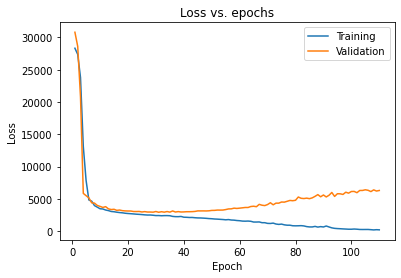

In [30]:
# Plot the training and validation loss
plt.plot(range(1,111), history.history["loss"])
plt.plot(range(1,111), history.history["val_loss"])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - because the model is overfitting the training data
    - overfitting
    - train on more data, use regularization, and use simpler network architecture

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

In [31]:
#### YOUR CODE HERE
# USING SIMPLER NETWORK ARCHITECTURE
# build the model
input_shape= train_data.shape[1]
model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(64, activation= "relu", input_dim=input_shape),
            tf.keras.layers.Dense(32, activation= "relu"),
            tf.keras.layers.Dense(16, activation= "relu"),
            tf.keras.layers.Dense(1, activation="linear")
        ]
    )
# compile the model 
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.MeanAbsoluteError()]
)
# fit model with training data
history = model.fit(train_data,train_targets, batch_size=64, epochs=110, validation_split=0.1)


Epoch 1/110


6/6 [==============================] - 1s 29ms/step - loss: 28596.7422 - mean_absolute_error: 150.6737 - val_loss: 31408.4531 - val_mean_absolute_error: 155.5117
Epoch 2/110
6/6 [==============================] - 0s 7ms/step - loss: 28498.1289 - mean_absolute_error: 150.3682 - val_loss: 31319.4727 - val_mean_absolute_error: 155.2473
Epoch 3/110
6/6 [==============================] - 0s 7ms/step - loss: 28421.1035 - mean_absolute_error: 150.1304 - val_loss: 31244.3086 - val_mean_absolute_error: 155.0208
Epoch 4/110
6/6 [==============================] - 0s 7ms/step - loss: 28358.3867 - mean_absolute_error: 149.9380 - val_loss: 31174.8906 - val_mean_absolute_error: 154.8148
Epoch 5/110
6/6 [==============================] - 0s 7ms/step - loss: 28294.7500 - mean_absolute_error: 149.7416 - val_loss: 31096.5000 - val_mean_absolute_error: 154.5874
Epoch 6/110
6/6 [==============================] - 0s 7ms/step - loss: 28220.4199 - mean_absolute_error: 149.5140 - val_loss: 31003.5625 - val_mea

In [32]:
#evaluate model on test data
model.evaluate(test_data,test_targets)

2/2 [==============================] - 0s 6ms/step - loss: 9586.3936 - mean_absolute_error: 78.2915


[9586.3935546875, 78.29151153564453]

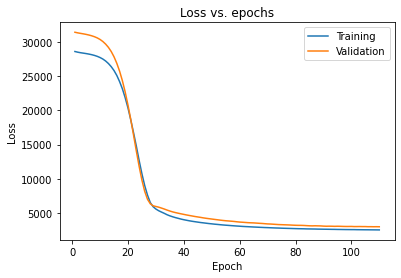

In [33]:
# Plot the training and validation loss
plt.plot(range(1,111), history.history["loss"])
plt.plot(range(1,111), history.history["val_loss"])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [34]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


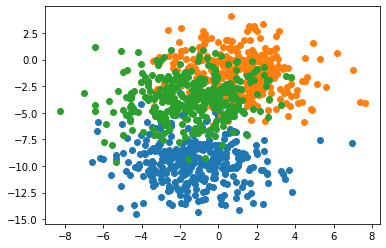

In [35]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [36]:
def build_model():
    ##### YOUR CODE HERE
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(50, activation="relu", input_dim=2, kernel_initializer="he_uniform"),
            tf.keras.layers.Dense(3, activation="softmax")
        ]
    )

    model.compile(
        optimizer= tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics= ["accuracy"]
    )
    
    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [37]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    model = build_model()
    history = model.fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test,y_test))

    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [38]:
### START CODE HERE ###
history = fit_model(X_train, y_train, X_test, y_test,1)
###### END CODE HERE

Epoch 1/125


500/500 [==============================] - 2s 3ms/step - loss: 2.2241 - accuracy: 0.4800 - val_loss: 0.9146 - val_accuracy: 0.5100
Epoch 2/125
500/500 [==============================] - 1s 2ms/step - loss: 1.0396 - accuracy: 0.5280 - val_loss: 1.0697 - val_accuracy: 0.5540
Epoch 3/125
500/500 [==============================] - 1s 2ms/step - loss: 0.9739 - accuracy: 0.5100 - val_loss: 0.8656 - val_accuracy: 0.6360
Epoch 4/125
500/500 [==============================] - 1s 3ms/step - loss: 0.8625 - accuracy: 0.6020 - val_loss: 0.8339 - val_accuracy: 0.6040
Epoch 5/125
500/500 [==============================] - 2s 3ms/step - loss: 0.9846 - accuracy: 0.5540 - val_loss: 0.9081 - val_accuracy: 0.5660
Epoch 6/125
500/500 [==============================] - 1s 3ms/step - loss: 0.9252 - accuracy: 0.5600 - val_loss: 0.8994 - val_accuracy: 0.5300
Epoch 7/125
500/500 [==============================] - 1s 3ms/step - loss: 0.8839 - accuracy: 0.5800 - val_loss: 0.9390 - val_accuracy: 0.5120
Epoch 8/125

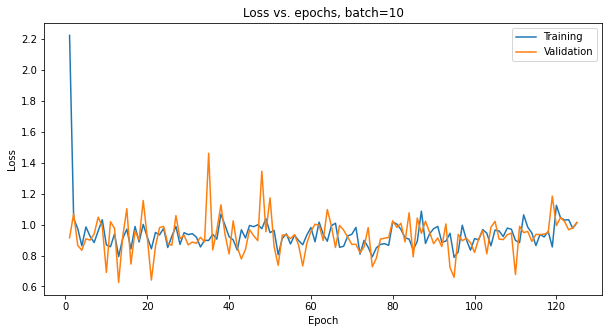

In [39]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: with respect to the learning rate, the plot shows that 0.01 is high learning rate that the model can't converge and the loss flactuates
- Change learning rate to make this curve better

In [40]:
### Your answer
lr = 0.00001

In [41]:
def build_model():
    ##### YOUR CODE HERE
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(50, activation="relu", input_dim=2, kernel_initializer="he_uniform"),
            tf.keras.layers.Dense(3, activation="softmax")
        ]
    )

    model.compile(
        optimizer= tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics= ["accuracy"]
    )
    
    
    return model

Epoch 1/125


500/500 [==============================] - 2s 3ms/step - loss: 1.2464 - accuracy: 0.6020 - val_loss: 1.0131 - val_accuracy: 0.6620
Epoch 2/125
500/500 [==============================] - 1s 2ms/step - loss: 1.0671 - accuracy: 0.6120 - val_loss: 0.9360 - val_accuracy: 0.6660
Epoch 3/125
500/500 [==============================] - 1s 2ms/step - loss: 0.9779 - accuracy: 0.6260 - val_loss: 0.8585 - val_accuracy: 0.6680
Epoch 4/125
500/500 [==============================] - 1s 2ms/step - loss: 0.8951 - accuracy: 0.6240 - val_loss: 0.7978 - val_accuracy: 0.6780
Epoch 5/125
500/500 [==============================] - 1s 2ms/step - loss: 0.8311 - accuracy: 0.6280 - val_loss: 0.7597 - val_accuracy: 0.6780
Epoch 6/125
500/500 [==============================] - 1s 2ms/step - loss: 0.7853 - accuracy: 0.6340 - val_loss: 0.7269 - val_accuracy: 0.6820
Epoch 7/125
500/500 [==============================] - 1s 2ms/step - loss: 0.7538 - accuracy: 0.6400 - val_loss: 0.7092 - val_accuracy: 0.6820
Epoch 8/125

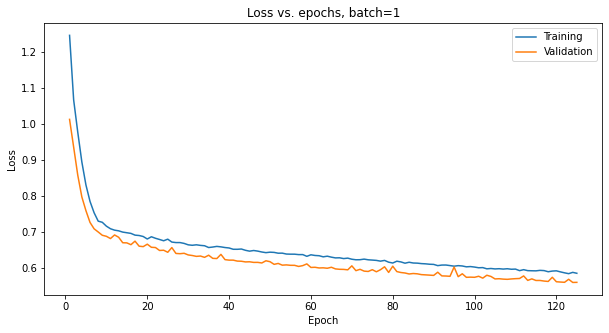

In [42]:
batch_size = 1
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [43]:
### START CODE HERE ###
batch_size = 16
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125


32/32 [==============================] - 1s 7ms/step - loss: 9.4353 - accuracy: 0.3320 - val_loss: 7.9176 - val_accuracy: 0.3240
Epoch 2/125
32/32 [==============================] - 0s 3ms/step - loss: 7.2150 - accuracy: 0.3280 - val_loss: 5.7778 - val_accuracy: 0.3160
Epoch 3/125
32/32 [==============================] - 0s 3ms/step - loss: 4.9651 - accuracy: 0.3200 - val_loss: 3.7231 - val_accuracy: 0.3020
Epoch 4/125
32/32 [==============================] - 0s 3ms/step - loss: 2.9360 - accuracy: 0.3160 - val_loss: 1.9595 - val_accuracy: 0.3080
Epoch 5/125
32/32 [==============================] - 0s 3ms/step - loss: 1.4698 - accuracy: 0.3340 - val_loss: 1.2094 - val_accuracy: 0.4200
Epoch 6/125
32/32 [==============================] - 0s 3ms/step - loss: 1.1121 - accuracy: 0.4200 - val_loss: 1.1489 - val_accuracy: 0.4580
Epoch 7/125
32/32 [==============================] - 0s 3ms/step - loss: 1.0883 - accuracy: 0.4500 - val_loss: 1.1311 - val_accuracy: 0.4680
Epoch 8/125
32/32 [======

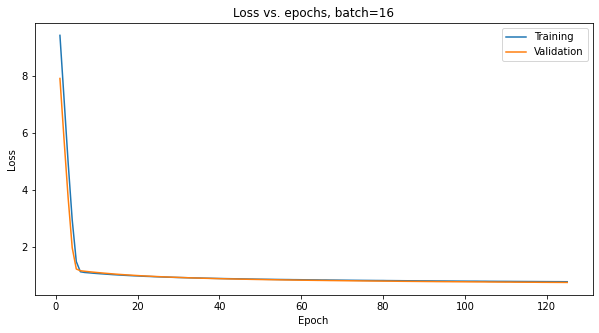

In [44]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [45]:
### START CODE HERE ###
batch_size = 128
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125


4/4 [==============================] - 0s 48ms/step - loss: 8.9110 - accuracy: 0.3580 - val_loss: 8.4923 - val_accuracy: 0.3480
Epoch 2/125
4/4 [==============================] - 0s 11ms/step - loss: 8.8230 - accuracy: 0.3620 - val_loss: 8.3738 - val_accuracy: 0.3480
Epoch 3/125
4/4 [==============================] - 0s 10ms/step - loss: 8.6759 - accuracy: 0.3660 - val_loss: 8.2162 - val_accuracy: 0.3540
Epoch 4/125
4/4 [==============================] - 0s 12ms/step - loss: 8.4997 - accuracy: 0.3640 - val_loss: 8.0319 - val_accuracy: 0.3540
Epoch 5/125
4/4 [==============================] - 0s 10ms/step - loss: 8.2929 - accuracy: 0.3660 - val_loss: 7.8366 - val_accuracy: 0.3640
Epoch 6/125
4/4 [==============================] - 0s 12ms/step - loss: 8.0832 - accuracy: 0.3720 - val_loss: 7.6343 - val_accuracy: 0.3640
Epoch 7/125
4/4 [==============================] - 0s 18ms/step - loss: 7.8601 - accuracy: 0.3800 - val_loss: 7.4339 - val_accuracy: 0.3740
Epoch 8/125
4/4 [===============

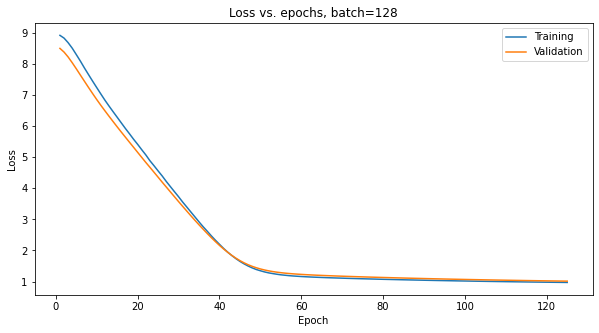

In [46]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [47]:
### START CODE HERE ###
batch_size = len(X_train)
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

Epoch 1/125


1/1 [==============================] - 0s 378ms/step - loss: 4.5441 - accuracy: 0.3320 - val_loss: 4.6438 - val_accuracy: 0.3300
Epoch 2/125
1/1 [==============================] - 0s 37ms/step - loss: 4.5372 - accuracy: 0.3320 - val_loss: 4.6311 - val_accuracy: 0.3300
Epoch 3/125
1/1 [==============================] - 0s 25ms/step - loss: 4.5242 - accuracy: 0.3320 - val_loss: 4.6130 - val_accuracy: 0.3300
Epoch 4/125
1/1 [==============================] - 0s 21ms/step - loss: 4.5056 - accuracy: 0.3320 - val_loss: 4.5902 - val_accuracy: 0.3300
Epoch 5/125
1/1 [==============================] - 0s 33ms/step - loss: 4.4820 - accuracy: 0.3320 - val_loss: 4.5629 - val_accuracy: 0.3300
Epoch 6/125
1/1 [==============================] - 0s 14ms/step - loss: 4.4540 - accuracy: 0.3320 - val_loss: 4.5318 - val_accuracy: 0.3300
Epoch 7/125
1/1 [==============================] - 0s 38ms/step - loss: 4.4219 - accuracy: 0.3320 - val_loss: 4.4971 - val_accuracy: 0.3300
Epoch 8/125
1/1 [==============

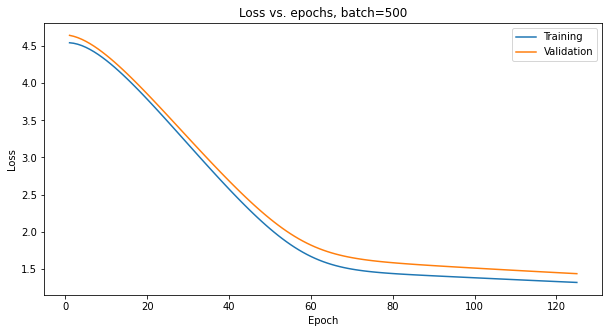

In [48]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:** With learning rate 0.00001, increasing the batch size results in smoother curve(less fluctuations) but ends with relatively higher loss (slower convergence)



#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [49]:
def build_model(lr):
    ##### YOUR CODE HERE
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(50, activation="relu", input_dim=2, kernel_initializer="he_uniform"),
            tf.keras.layers.Dense(3, activation="softmax")
        ]
    )

    model.compile(
        optimizer= tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics= ["accuracy"]
    )
    return model

def fit_model(X_train, y_train, X_test, y_test, lr):
    ##### YOUR CODE HERE
    model = build_model(lr)
    history = model.fit(X_train, y_train, epochs=125, batch_size=64, validation_data=(X_test,y_test))
    
    return history

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [50]:
### START CODE HERE ### ()
lr = 0.00001
history = fit_model(X_train, y_train, X_test, y_test, lr)

Epoch 1/125


8/8 [==============================] - 0s 21ms/step - loss: 2.2951 - accuracy: 0.2300 - val_loss: 2.2086 - val_accuracy: 0.2320
Epoch 2/125
8/8 [==============================] - 0s 6ms/step - loss: 2.2419 - accuracy: 0.2380 - val_loss: 2.1524 - val_accuracy: 0.2460
Epoch 3/125
8/8 [==============================] - 0s 6ms/step - loss: 2.1701 - accuracy: 0.2540 - val_loss: 2.0933 - val_accuracy: 0.2520
Epoch 4/125
8/8 [==============================] - 0s 4ms/step - loss: 2.1043 - accuracy: 0.2680 - val_loss: 2.0351 - val_accuracy: 0.2620
Epoch 5/125
8/8 [==============================] - 0s 6ms/step - loss: 2.0359 - accuracy: 0.2780 - val_loss: 1.9840 - val_accuracy: 0.2680
Epoch 6/125
8/8 [==============================] - 0s 6ms/step - loss: 1.9804 - accuracy: 0.2860 - val_loss: 1.9345 - val_accuracy: 0.2740
Epoch 7/125
8/8 [==============================] - 0s 4ms/step - loss: 1.9251 - accuracy: 0.2900 - val_loss: 1.8884 - val_accuracy: 0.2820
Epoch 8/125
8/8 [=====================

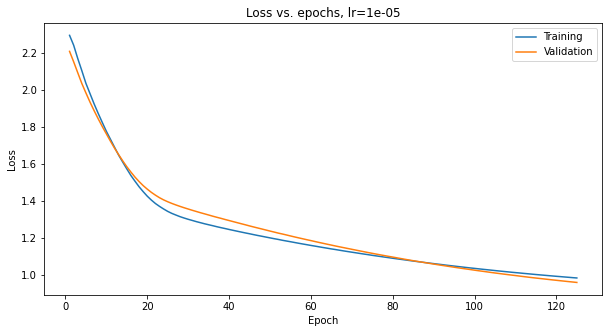

In [51]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [52]:
### START CODE HERE ### ()
lr = 0.001
history = fit_model(X_train, y_train, X_test, y_test, lr)

Epoch 1/125


8/8 [==============================] - 0s 19ms/step - loss: 2.8408 - accuracy: 0.3820 - val_loss: 2.2099 - val_accuracy: 0.2960
Epoch 2/125
8/8 [==============================] - 0s 5ms/step - loss: 1.6687 - accuracy: 0.3700 - val_loss: 1.4556 - val_accuracy: 0.4120
Epoch 3/125
8/8 [==============================] - 0s 7ms/step - loss: 1.2280 - accuracy: 0.5040 - val_loss: 0.9337 - val_accuracy: 0.6360
Epoch 4/125
8/8 [==============================] - 0s 4ms/step - loss: 0.9005 - accuracy: 0.6000 - val_loss: 0.8011 - val_accuracy: 0.6760
Epoch 5/125
8/8 [==============================] - 0s 5ms/step - loss: 0.8371 - accuracy: 0.6020 - val_loss: 0.7448 - val_accuracy: 0.6880
Epoch 6/125
8/8 [==============================] - 0s 7ms/step - loss: 0.7726 - accuracy: 0.6200 - val_loss: 0.7154 - val_accuracy: 0.6860
Epoch 7/125
8/8 [==============================] - 0s 6ms/step - loss: 0.7423 - accuracy: 0.6360 - val_loss: 0.6877 - val_accuracy: 0.6800
Epoch 8/125
8/8 [=====================

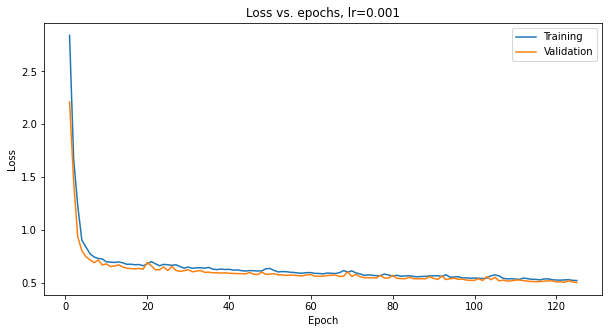

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [54]:
### START CODE HERE ### ()
lr = 0.1
history = fit_model(X_train, y_train, X_test, y_test, lr)

Epoch 1/125


8/8 [==============================] - 0s 19ms/step - loss: 5.4303 - accuracy: 0.4640 - val_loss: 2.2373 - val_accuracy: 0.6700
Epoch 2/125
8/8 [==============================] - 0s 6ms/step - loss: 1.2703 - accuracy: 0.6180 - val_loss: 1.2682 - val_accuracy: 0.6280
Epoch 3/125
8/8 [==============================] - 0s 6ms/step - loss: 0.9449 - accuracy: 0.6480 - val_loss: 0.7487 - val_accuracy: 0.7560
Epoch 4/125
8/8 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.7700 - val_loss: 0.7161 - val_accuracy: 0.7220
Epoch 5/125
8/8 [==============================] - 0s 7ms/step - loss: 0.6313 - accuracy: 0.7520 - val_loss: 0.5690 - val_accuracy: 0.8000
Epoch 6/125
8/8 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.7820 - val_loss: 0.5411 - val_accuracy: 0.7920
Epoch 7/125
8/8 [==============================] - 0s 5ms/step - loss: 0.5160 - accuracy: 0.7820 - val_loss: 0.5615 - val_accuracy: 0.7500
Epoch 8/125
8/8 [=====================

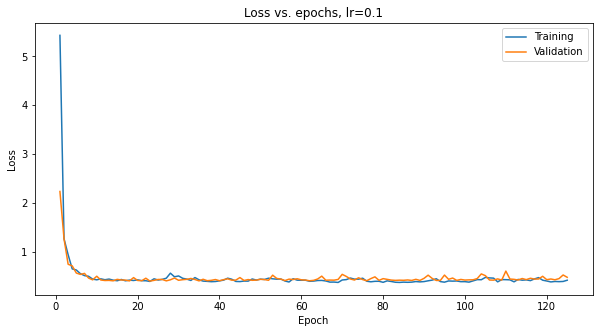

In [55]:
plt.figure(figsize=(10,5))
plt.plot(range(1,126), history.history["loss"])
plt.plot(range(1,126), history.history["val_loss"])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**





**Answer:** with batch size = 64, increasing the learning rate results in less smoother cuvres(more fluctuations), but ends with relatively lower loss(higher convergence)

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:**  essential for automatic differentiation (Backpropagation)

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1. use `tf.data` API to create data input pipelines to load and preprocess data

2. use Keras data loading utilities located in `tf.keras.utils` to go from raw data on disk to a `tf.data.Dataset` object that can be used to train a model.